In [13]:
!pip install -q python-igraph scikit-learn

In [14]:
import torch
from torch.utils.data import Subset
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt

# Define the transformation pipeline:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x > 0.5).float()),  # Binarize the image
    transforms.Lambda(lambda x: x.view(-1))           # Flatten into a 784-dim vector
])

# Load the training set (set download=True if running for the first time)
mnist_train = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Get indices for images where the label is 1
indices = (mnist_train.targets == 1).nonzero().squeeze()

# Create a subset containing only the '1's
mnist_train_ones = Subset(mnist_train, indices)

print(f"Total number of '1' images in the training set: {len(mnist_train_ones)}")

# Stack all 784-dim vectors from the filtered dataset
all_vectors = torch.stack([img for img, _ in mnist_train_ones])
unique_vectors = torch.unique(all_vectors, dim=0)

print(f"Total images in mnist_train_ones: {all_vectors.shape[0]}")
print(f"Unique images: {unique_vectors.shape[0]}")

if all_vectors.shape[0] == unique_vectors.shape[0]:
    print("All 784-dimensional vectors are unique.")
else:
    print("There are duplicates in the 784-dimensional vectors.")



Total number of '1' images in the training set: 6742
Total images in mnist_train_ones: 6742
Unique images: 6726
There are duplicates in the 784-dimensional vectors.


In [15]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
import igraph as ig

def visualize_threshold_graph_igraph_weighted(unique_vectors, distance_threshold):
    """
    Builds a weighted graph with python-igraph where each unique vector is a node
    and an edge is added between nodes if their Euclidean distance is <= distance_threshold.
    The edge is weighted by the real Euclidean distance between the nodes.

    Args:
        unique_vectors (torch.Tensor or np.array): Array/tensor of shape (n, 784) containing unique images.
        distance_threshold (float): Maximum Euclidean distance for adding an edge between two nodes.

    Returns:
        g (igraph.Graph): The constructed weighted graph.
    """
    # Convert tensor to numpy array if necessary.
    if hasattr(unique_vectors, 'numpy'):
        X = unique_vectors.numpy()
    else:
        X = unique_vectors

    n = X.shape[0]
    print(f"Building weighted graph for {n} nodes...")

    # Use NearestNeighbors to find all pairs within the distance threshold.
    nbrs = NearestNeighbors(radius=distance_threshold, algorithm='auto').fit(X)
    distances, indices = nbrs.radius_neighbors(X)

    # Build lists of edges and corresponding weights.
    edge_list = []
    weights = []
    for i, (dists, neigh) in enumerate(zip(distances, indices)):
        # For each neighbor j of node i, add edge only if i < j to avoid duplicates.
        for d, j in zip(dists, neigh):
            if i < j:
                edge_list.append((i, j))
                weights.append(d)

    # Create an undirected graph using python-igraph.
    g = ig.Graph(n=n, edges=edge_list, directed=False)
    # Set the edge weight attribute.
    g.es['weight'] = weights

    print(f"Weighted graph built with {len(edge_list)} edges.")
    return g

# Example usage:
g = visualize_threshold_graph_igraph_weighted(unique_vectors, distance_threshold=6)


Building weighted graph for 6726 nodes...
Weighted graph built with 4681902 edges.


In [16]:
import numpy as np
import torch
from torch.utils.data import TensorDataset

# Assume:
#   - g is your igraph Graph from the previous cell.
#   - unique_vectors is a torch.Tensor of shape (n, 784) where n is the number of nodes in g.

# Compute connected components of the graph.
clusters = g.connected_components()
# Find the index (label) of the largest component.
largest_cluster_index = np.argmax(clusters.sizes())
# Get the indices of nodes belonging to the largest component.
vertex_indices = [i for i, comp in enumerate(clusters.membership) if comp == largest_cluster_index]

print(f"Largest connected component has {len(vertex_indices)} nodes.")

# Convert the vertex indices list to a torch tensor.
vertex_indices_tensor = torch.tensor(vertex_indices, dtype=torch.long)

# Use these indices to select the corresponding vectors.
largest_component_vectors = unique_vectors[vertex_indices_tensor]
print("Shape of largest component vectors:", largest_component_vectors.shape)

# Create a TensorDataset with these vectors.
unique_dataset = TensorDataset(largest_component_vectors)
print("TensorDataset created with largest connected component vectors.")


Largest connected component has 6631 nodes.
Shape of largest component vectors: torch.Size([6631, 784])
TensorDataset created with largest connected component vectors.


In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Subset
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt

# Define a simple autoencoder architecture
class Autoencoder(nn.Module):
    def __init__(self, latent_dim=32):
        super(Autoencoder, self).__init__()
        # Encoder: 784 -> 256 -> 128 -> latent_dim
        self.encoder = nn.Sequential(
            nn.Linear(784, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim),
            nn.ReLU()
        )
        # Decoder: latent_dim -> 128 -> 256 -> 784
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 784),
            nn.Sigmoid()  # Output between 0 and 1
        )

    def forward(self, x):
        z = self.encoder(x)
        reconstructed = self.decoder(z)
        return reconstructed

    def get_latent(self, x):
        return self.encoder(x)

# Training parameters
batch_size = 256
num_epochs = 50
learning_rate = 0.001
latent_dim = 32

# Create DataLoader for the unique dataset
unique_loader = DataLoader(unique_dataset, batch_size=batch_size, shuffle=True)

# Set up device and model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Autoencoder(latent_dim=latent_dim).to(device)

# Loss function and optimizer
criterion = nn.BCELoss()  # Use binary cross entropy since inputs are binary
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop for the autoencoder on unique vectors
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch in unique_loader:
        images = batch[0].to(device)  # images shape: [batch_size, 784]
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(unique_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

# Extract latent representations for analysis or visualization
model.eval()
with torch.no_grad():
    sample_batch = next(iter(unique_loader))[0].to(device)
    latent_codes = model.get_latent(sample_batch)
    print("Latent representations shape:", latent_codes.shape)


Epoch [1/50], Loss: 0.4120
Epoch [2/50], Loss: 0.1271
Epoch [3/50], Loss: 0.1164
Epoch [4/50], Loss: 0.1123
Epoch [5/50], Loss: 0.1077
Epoch [6/50], Loss: 0.0803
Epoch [7/50], Loss: 0.0680
Epoch [8/50], Loss: 0.0631
Epoch [9/50], Loss: 0.0556
Epoch [10/50], Loss: 0.0519
Epoch [11/50], Loss: 0.0505
Epoch [12/50], Loss: 0.0498
Epoch [13/50], Loss: 0.0493
Epoch [14/50], Loss: 0.0489
Epoch [15/50], Loss: 0.0487
Epoch [16/50], Loss: 0.0483
Epoch [17/50], Loss: 0.0479
Epoch [18/50], Loss: 0.0468
Epoch [19/50], Loss: 0.0429
Epoch [20/50], Loss: 0.0401
Epoch [21/50], Loss: 0.0388
Epoch [22/50], Loss: 0.0378
Epoch [23/50], Loss: 0.0370
Epoch [24/50], Loss: 0.0365
Epoch [25/50], Loss: 0.0361
Epoch [26/50], Loss: 0.0358
Epoch [27/50], Loss: 0.0354
Epoch [28/50], Loss: 0.0351
Epoch [29/50], Loss: 0.0346
Epoch [30/50], Loss: 0.0341
Epoch [31/50], Loss: 0.0333
Epoch [32/50], Loss: 0.0325
Epoch [33/50], Loss: 0.0316
Epoch [34/50], Loss: 0.0311
Epoch [35/50], Loss: 0.0305
Epoch [36/50], Loss: 0.0298
E

In [18]:
import torch
import numpy as np

def compare_distances(model, dataset, device, sample_size=50):
    # Randomly sample sample_size images from the dataset
    indices = torch.randperm(len(dataset))[:sample_size]
    sample = torch.stack([dataset[i][0] for i in indices]).to(device)  # [sample_size, 784]

    # Get latent representation for the sample
    model.eval()
    with torch.no_grad():
        latent = model.get_latent(sample)  # [sample_size, latent_dim]

    # Compute pairwise Euclidean distances in the original and latent spaces
    dist_original = torch.cdist(sample, sample, p=2)
    dist_latent = torch.cdist(latent, latent, p=2)

    # Compute correlation between the flattened distance matrices
    corr = np.corrcoef(dist_original.cpu().numpy().flatten(),
                       dist_latent.cpu().numpy().flatten())[0, 1]
    print("Correlation (Euclidean distances) between original and latent spaces:", corr)

    return dist_original, dist_latent


In [19]:
dist_original, dist_latent = compare_distances(model, unique_dataset, device, sample_size=100)

Correlation (Euclidean distances) between original and latent spaces: 0.8459333378743492


In [20]:
# Compute latent representations for each unique vector using the autoencoder
model.eval()
with torch.no_grad():
    latent_vectors = model.get_latent(unique_vectors)

print("Latent representations shape:", latent_vectors.shape)

# Build a weighted graph from the latent representations using the pre-defined function
g_latent = visualize_threshold_graph_igraph_weighted(latent_vectors, distance_threshold=6)

# Find connected components in the latent graph
clusters_latent = g_latent.connected_components()
largest_component_index = np.argmax(clusters_latent.sizes())
largest_component_nodes = clusters_latent[largest_component_index]

# Create a subgraph of the largest connected component
subgraph = g_latent.subgraph(largest_component_nodes)

# Print the number of nodes and edges in the largest connected component
print("Largest connected component:")
print("Number of nodes:", subgraph.vcount())
print("Number of edges:", subgraph.ecount())



Latent representations shape: torch.Size([6726, 32])
Building weighted graph for 6726 nodes...
Weighted graph built with 88253 edges.
Largest connected component:
Number of nodes: 6314
Number of edges: 87407


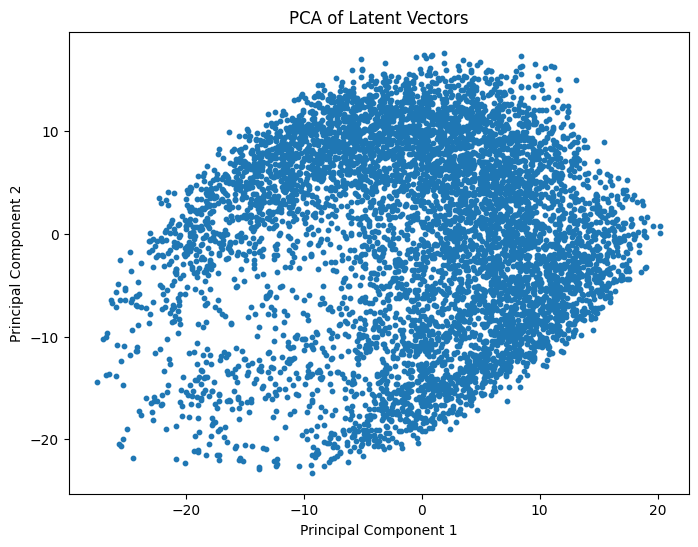

In [28]:
# prompt: pca for latent_vectors and display

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Apply PCA to reduce the dimensionality of the latent vectors to 2
pca = PCA(n_components=2)
latent_vectors_2d = pca.fit_transform(latent_vectors.cpu().numpy())

# Plot the latent vectors in 2D
plt.figure(figsize=(8, 6))
plt.scatter(latent_vectors_2d[:, 0], latent_vectors_2d[:, 1], s=10)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA of Latent Vectors")
plt.show()


In [21]:
def compare_graph_connectivity(g_orig, g_latent):
    """
    For each node, print the neighbors in the original and latent graphs,
    and compute the symmetric difference between the two neighbor sets.
    Then, identify nodes with the greatest differences.
    """
    differences = {}
    for node in range(g_orig.vcount()):
        # Get neighbor sets from both graphs
        neighbors_orig = set(g_orig.neighbors(node))
        neighbors_latent = set(g_latent.neighbors(node))
        # Compute symmetric difference
        diff = neighbors_orig.symmetric_difference(neighbors_latent)
        differences[node] = diff

        # print(f"Node {node}:")
        # print(f"  Original neighbors: {sorted(neighbors_orig)}")
        # print(f"  Latent neighbors:   {sorted(neighbors_latent)}")
        # print(f"  Difference:         {sorted(diff)}\n")

    # Identify nodes with the greatest differences
    diff_counts = {node: len(diff) for node, diff in differences.items()}
    max_diff_nodes = sorted(diff_counts.items(), key=lambda x: x[1], reverse=True)[:5]

    print("Nodes with greatest connectivity differences:")
    for node, count in max_diff_nodes:
        print(f"  Node {node} has {count} differing connections.")

    return differences

# Compare connectivity between the original graph 'g' and the latent graph 'g_latent'
diffs = compare_graph_connectivity(g, g_latent)

# Print total edge counts for both graphs
print(f"\nTotal edges in original graph: {g.ecount()}")
print(f"Total edges in latent graph:   {g_latent.ecount()}")


Nodes with greatest connectivity differences:
  Node 3930 has 2522 differing connections.
  Node 1352 has 2505 differing connections.
  Node 5131 has 2502 differing connections.
  Node 1275 has 2492 differing connections.
  Node 1403 has 2489 differing connections.

Total edges in original graph: 4681902
Total edges in latent graph:   88253


In [22]:
import igraph as ig

# Assume g and g_latent have the same number of nodes (n)
n = g.vcount()
print("Number of nodes in each graph:", n)

# Create a new combined graph with 2n nodes.
combined_graph = ig.Graph()
combined_graph.add_vertices(2 * n)

# Add edges from the original graph (nodes 0 to n-1)
original_edges = g.get_edgelist()  # Edges between nodes in range [0, n-1]
combined_graph.add_edges(original_edges)

# Add edges from the latent graph (offset nodes by n, so they lie in [n, 2n-1])
latent_edges = g_latent.get_edgelist()  # Edges between nodes in range [0, n-1]
offset_latent_edges = [(u + n, v + n) for u, v in latent_edges]
combined_graph.add_edges(offset_latent_edges)

# Add bridging edges: connect each original node with its corresponding latent representation
bridging_edges = [(i, i + n) for i in range(n)]
combined_graph.add_edges(bridging_edges)

# Print summary information
print("Combined graph:")
print("  Number of nodes:", combined_graph.vcount())
print("  Number of edges:", combined_graph.ecount())


Number of nodes in each graph: 6726
Combined graph:
  Number of nodes: 13452
  Number of edges: 4776881


In [23]:
# Compute reconstructed images from the unique vectors using the autoencoder
model.eval()
with torch.no_grad():
    reconstructed_vectors = model(unique_vectors)
print("Reconstructed vectors shape:", reconstructed_vectors.shape)

# Build a weighted graph from the reconstructed vectors using the same function
g_reconstructed = visualize_threshold_graph_igraph_weighted(reconstructed_vectors, distance_threshold=6)
print("Graph for reconstructed vectors (g_reconstructed) created.")


Reconstructed vectors shape: torch.Size([6726, 784])
Building weighted graph for 6726 nodes...
Weighted graph built with 7939907 edges.
Graph for reconstructed vectors (g_reconstructed) created.


In [24]:
import igraph as ig

# Assume g and g_reconstructed have the same number of nodes (n)
n = g.vcount()
print("Number of nodes in each graph:", n)

# Create a new combined graph with 2n nodes.
combined_graph = ig.Graph()
combined_graph.add_vertices(2 * n)

# Add edges from the original graph (nodes 0 to n-1)
original_edges = g.get_edgelist()  # Edges between nodes in range [0, n-1]
combined_graph.add_edges(original_edges)

# Add edges from the reconstructed graph (offset nodes by n, so they lie in [n, 2n-1])
reconstructed_edges = g_reconstructed.get_edgelist()  # Edges between nodes in range [0, n-1]
offset_reconstructed_edges = [(u + n, v + n) for u, v in reconstructed_edges]
combined_graph.add_edges(offset_reconstructed_edges)

# Add bridging edges: connect each original node with its corresponding reconstructed representation
bridging_edges = [(i, i + n) for i in range(n)]
combined_graph.add_edges(bridging_edges)

# Print summary information
print("Combined graph:")
print("  Number of nodes:", combined_graph.vcount())
print("  Number of edges:", combined_graph.ecount())


Number of nodes in each graph: 6726
Combined graph:
  Number of nodes: 13452
  Number of edges: 12628535


In [29]:
!pip install triangle


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 20.8 MB/s eta 0:00:00


In [39]:
import random
from collections import deque

def get_connected_subset(g, subset_size=100, seed=None):
    """
    Extract a connected subset of nodes from graph g using BFS.

    Args:
        g (igraph.Graph): The input connected graph.
        subset_size (int): Number of nodes to extract.
        seed (int, optional): Random seed for reproducibility.

    Returns:
        list: List of node indices that form a connected subset.
    """
    if seed is not None:
        random.seed(seed)
    start = random.choice(range(g.vcount()))
    visited = set([start])
    queue = deque([start])

    while len(visited) < subset_size and queue:
        current = queue.popleft()
        for neighbor in g.neighbors(current):
            if neighbor not in visited:
                visited.add(neighbor)
                queue.append(neighbor)
                if len(visited) >= subset_size:
                    break

    # If you couldn't reach the desired size (which might happen on small graphs)
    if len(visited) < subset_size:
        print(f"Warning: Only found {len(visited)} connected nodes.")
    return list(visited)

# Assume g is your largest component graph from the original data.
subset_nodes = get_connected_subset(g, subset_size=10, seed=42)

# Create the induced subgraph for the selected nodes.
g_subset = g.subgraph(subset_nodes)

print("Subset graph (100 connected nodes):")
print("  Number of nodes:", g_subset.vcount())
print("  Number of edges:", g_subset.ecount())


Subset graph (100 connected nodes):
  Number of nodes: 10
  Number of edges: 41


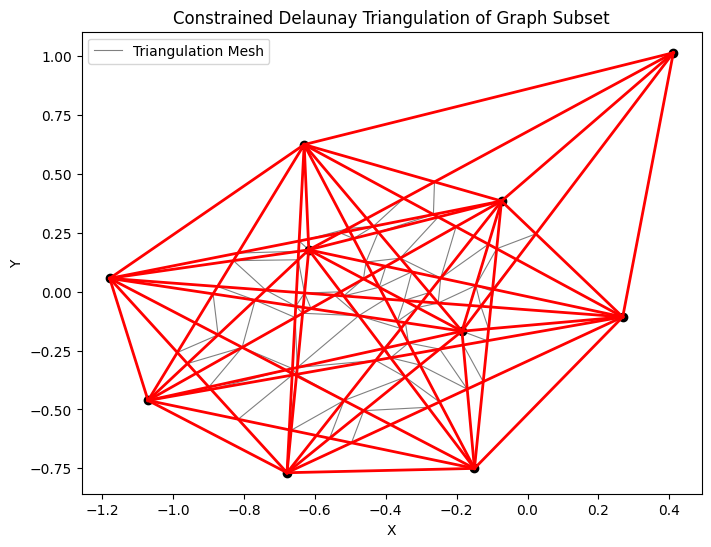

In [40]:
import igraph as ig
import numpy as np
import triangle as tr
import matplotlib.pyplot as plt

# ---- Assume g_subset is your connected subgraph with 100 nodes ----
# For visualization, we first need to embed these nodes in 2D.
# Using a force-directed layout (Fruchterman-Reingold) for a 2D projection:
layout = g_subset.layout("fr")  # 'fr' is the Fruchterman-Reingold layout
points = np.array(layout.coords)  # points is an array of shape (100, 2)

# Get forced segments (i.e., the edges in the subgraph).
# The get_edgelist() returns a list of tuples (u, v) of node indices.
segments = np.array(g_subset.get_edgelist())

# Build the PSLG (Planar Straight Line Graph) for constrained Delaunay triangulation.
pslg = dict(vertices=points, segments=segments)

# Perform the constrained triangulation using the 'p' option (PSLG input).
triangulation = tr.triangulate(pslg, 'p')

# ---- Plotting the result ----
plt.figure(figsize=(8, 6))

# Plot the triangulation: the triangles computed by the algorithm.
plt.triplot(triangulation['vertices'][:, 0],
            triangulation['vertices'][:, 1],
            triangulation['triangles'],
            color='gray', lw=0.8, label="Triangulation Mesh")

# Now draw the forced (original) segments in red.
for seg in segments:
    # Extract the coordinates of the segment's endpoints.
    pts = points[seg]
    plt.plot(pts[:, 0], pts[:, 1], 'r-', lw=2)

# Plot the nodes as black points.
plt.scatter(points[:, 0], points[:, 1], color='black')

plt.title("Constrained Delaunay Triangulation of Graph Subset")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.show()
